### Explanation of dynamic programming

We create a list of switch points 

In [ ]:
# %load PieceWise.py
import pandas as pd
from numpy import *
class encoder:
    """
    The encoder/decoder class is the base class for all encoder/decoder pairs.
    Subclasses encode different types of encoding.
    EncoderLearner is a factory class for fitting encoders to data
    """
    def __init__(self,raw):
        """
        given a Pandas DataFrame or Series (raw), find the best model of a given type
        """
    
    def compress(self):
        """
        given a raw sequence and a model, return a compressed representation.
        """
        self.compressed=None
        return self.compressed
    
    def recon(self,compressed):
        """
        Recreate the original DataFrame or Series, possibly with errors.
        """
        Recon=None
        return Recon
    
    def get_size(self):
        return len(self.compressed)
    
    def compute_error(self,S,compressed=None):
        if type(compressed)==type(None):
            compressed=self.compressed
        R=self.recon(compressed=compressed,index=S.index)
        V=R-S
        V.dropna()
        return sqrt(sum([v*v for v in V.values]))/len(V)
    
class piecewise_constant(encoder):
    """ 
    Represent the signal using a sequence of piecewise constant functions 
    """
    def __init__(self,raw):
        if type(raw) != pd.Series:
            raise 'encode expects pandas Series as input'
        self.index=raw.index
        self.Sol=self.fit(raw)
    
    # fit uses dynamic programming to find the best piecewise constant solution
    # max_gap is the maximal extent of a single step.
    # Reason for max_gap is that even if the error is small we want to correct
    # it with some minimal frequence. 
    # Not quite a snapshot because the value will not necessarily change after 
    # max_gap is reached.
    def fit(self,S,max_gap=96):
        S[isnan(S)]=0
        _range=max(S)-min(S)
        # _range is a constant that is added to the error at each stop point
        # Larger values will cause fewer switches.
        print 'range=',_range
        #Dynamic programming
        Sol=[[]]*len(S)  # an array that holds the best partition ending at each point of the sequence.
                # Each element contains a best current value, a pointer to the last change in best 
                # solution so far and the total error of best solution so far.
        for i in range(len(S)):
            if i==0:
                Sol[i]={'prev':None, 'value':S[0], 'error':0.0, 'switch_no':0}
            # Sol is indexed by the location in the sequence S
            # prev: the index of the last switch point
            # value: current prediction value
            # error: cumulative error to this point
            # switch_no: number of switches so far.
            else:
                err0 = Sol[i-1]['error']+(Sol[i-1]['value']-S[i])**2
                best=None
                best_err=1e20
                best_val=S[i]
                for j in range(max(0,i-max_gap),i):
                    _mean=mean(S[j:i])
                    _std=std(S[j:i])
                    err=_std*(i-j)+Sol[j]['error']+_range
                    if err<best_err:
                        best=j
                        best_val=_mean
                        best_err=err
                Sol[i]={'prev':best, 'value':best_val, 'error':best_err,\
                        'switch_no': Sol[best]['switch_no']+1}
            #print '\r',i,Sol[i],
        return Sol
    
    def compress(self):
        Switch_points=[]
        i=len(self.Sol)-1                # start from the end 
        while i>0:
            prev=self.Sol[i]['prev']
            value=self.Sol[i]['value']
            if self.Sol[prev]['value'] != value:
                Switch_points.append({'time':S.index[prev],'value':value})
            i=prev
        self.compressed=Switch_points
        return Switch_points

    def recon(self,compressed=None, index=None):
        #print '\nindex=',index==None,'\n'
        #print '\ncompressed=',compressed==None,'\n'
        if(type(index)==type(None)):
            index=self.index
        Recon=pd.Series(index=index)
        
        if(type(compressed)==type(None)):
            compressed=self.compressed
        for e in compressed:
            time=e['time']
            value=e['value']
            Recon[time]=value
            
        return Recon.fillna(method='ffill')

import pickle
import pandas as pd 
import sys

out=open('Compressed.pkl','w')
A=pickle.load(open('New150Days.pkl','r'))
print 'shape before dropping Room==nan =',shape(A)
A=A.dropna(subset=['Room'])
print 'shape after dropping Room==nan =',shape(A)
rooms=sorted(list(set(A.Room.values)))

print 'starting Piecewise, rooms=',rooms
sys.stdout.flush()

cols = list(A.columns)
cols.remove('Room')
cols.remove('Temperature')

for room in rooms[:10]:
    print '-'*20,room,'-'*20
    sys.stdout.flush()
    DF = A[A['Room']==room]
    DF = DF.drop('Room', 1)  # remove the entry "Room"
    for name in cols:
        S=DF[name]
        #S=S[100:200]
        _std=std(S)
        print 'room=',room,'signal=',name, 'std=',_std,
        
        encoder=piecewise_constant(S)
        C=encoder.compress()
        print 'size=',encoder.get_size(),
        error=encoder.compute_error(S,compressed=C)
        print 'error=',error, 'error/_std=',error/_std
        pickle.dump({'name':name,
                     'room':room,
                     'code':C
                     }, out)
out.close()


shape before dropping Room==nan = (3384940, 16)
shape after dropping Room==nan = (3384912, 16)
starting Piecewise, rooms= ['1100A', '1100D', '1102', '1104', '1106', '1107', '1108', '1109', '1110', '1113', '1115', '1116', '1117', '1122', '1123', '1124', '1125', '1126', '1130', '1132', '1133', '1134', '1139', '1144', '1145', '1150', '1151', '1154', '1155', '1156', '1200A', '1200B', '1200C', '1203', '1207', '1208', '1208B', '1212', '1213', '1213A', '1217', '1218', '1221', '1223', '1224', '1229', '1230', '1231', '1236', '2102', '2105', '2107', '2108', '2109', '2111', '2112', '2116', '2118', '2119', '2121', '2122', '2126', '2127', '2128', '2130', '2132', '2134', '2136', '2138', '2140', '2142', '2144', '2146', '2148', '2150', '2154', '2200A', '2203', '2207', '2208', '2209', '2214', '2215', '2217', '2218', '2219', '2221', '2226', '2227', '2229A', '2230', '2231', '2232', '2234', '2236', '2238', '2240', '2244', '2250', '2256', '2262', '2266', '2270', '2272', '3102', '3105', '3106', '3107', '310

In [2]:
import pandas as pd
from numpy import *
class encoder:
    """
    The encoder/decoder class is the base class for all encoder/decoder pairs.
    Subclasses encode different types of encoding.
    EncoderLearner is a factory class for fitting encoders to data
    """
    def __init__(self,raw):
        """
        given a Pandas DataFrame or Series (raw), find the best model of a given type
        """
    
    def compress(self):
        """
        given a raw sequence and a model, return a compressed representation.
        """
        self.compressed=None
        return self.compressed
    
    def recon(self,compressed):
        """
        Recreate the original DataFrame or Series, possibly with errors.
        """
        Recon=None
        return Recon
    
    def get_size(self):
        return len(self.compressed)
    
    def compute_error(self,S,compressed=None):
        if type(compressed)==type(None):
            compressed=self.compressed
        R=self.recon(compressed=compressed,index=S.index)
        V=R-S
        V.dropna()
        return sqrt(sum([v*v for v in V.values]))/len(V)
    
class piecewise_constant(encoder):
    """ 
    Represent the signal using a sequence of piecewise constant functions 
    """
    def __init__(self,raw):
        if type(raw) != pd.Series:
            raise 'encode expects pandas Series as input'
        self.index=raw.index
        self.Sol=self.fit(raw)
    
    def fit(self,S,max_gap=96):
        S[isnan(S)]=0
        _range=max(S)-min(S)
        print 'range=',_range
        #Dynamic programming
        Sol=[[]]*len(S)  # an array that holds the best partition ending at each point of the sequence.
                # Each element contains a best current value, a pointer to the last change in best 
                # solution so far and the total error of best solution so far.
        for i in range(len(S)):
            if i==0:
                Sol[i]={'prev':None, 'value':S[0], 'error':0.0, 'switch_no':0}
            else:
                err0 = Sol[i-1]['error']+(Sol[i-1]['value']-S[i])**2
                best=None
                best_err=1e20
                best_val=S[i]
                for j in range(max(0,i-max_gap),i):
                    _mean=mean(S[j:i])
                    _std=std(S[j:i])
                    err=_std*(i-j)+Sol[j]['error']+_range
                    if err<best_err:
                        best=j
                        best_val=_mean
                        best_err=err
                Sol[i]={'prev':best, 'value':best_val, 'error':best_err,\
                        'switch_no': Sol[best]['switch_no']+1}
            #print '\r',i,Sol[i],
        return Sol
    
    def compress(self):
        Switch_points=[]
        i=len(self.Sol)-1                # start from the end 
        while i>0:
            prev=self.Sol[i]['prev']
            value=self.Sol[i]['value']
            if self.Sol[prev]['value'] != value:
                Switch_points.append({'time':S.index[prev],'value':value})
            i=prev
        self.compressed=Switch_points
        return Switch_points

    def recon(self,compressed=None, index=None):
        #print '\nindex=',index==None,'\n'
        #print '\ncompressed=',compressed==None,'\n'
        if(type(index)==type(None)):
            index=self.index
        Recon=pd.Series(index=index)
        
        if(type(compressed)==type(None)):
            compressed=self.compressed
        for e in compressed:
            time=e['time']
            value=e['value']
            Recon[time]=value
            
        return Recon.fillna(method='ffill')

import pickle
import pandas as pd 
import sys

out=open('Compressed.pkl','w')
A=pickle.load(open('New150Days.pkl','r'))
print 'shape before dropping Room==nan =',shape(A)
A=A.dropna(subset=['Room'])
print 'shape after dropping Room==nan =',shape(A)
rooms=sorted(list(set(A.Room.values)))

print 'starting Piecewise, rooms=',rooms
sys.stdout.flush()

cols = list(A.columns)
cols.remove('Room')
cols.remove('Temperature')

for room in rooms[:10]:
    print '-'*20,room,'-'*20
    sys.stdout.flush()
    DF = A[A['Room']==room]
    DF = DF.drop('Room', 1)  # remove the entry "Room"
    for name in cols:
        S=DF[name]
        #S=S[100:200]
        _std=std(S)
        print 'room=',room,'signal=',name, 'std=',_std,
        
        encoder=piecewise_constant(S)
        C=encoder.compress()
        print 'size=',encoder.get_size(),
        error=encoder.compute_error(S,compressed=C)
        print 'error=',error, 'error/_std=',error/_std
        pickle.dump({'name':name,
                     'room':room,
                     'code':C
                     }, out)
out.close()


shape before dropping Room==nan = (3384940, 16)
shape after dropping Room==nan = (3384912, 16)
starting Piecewise, rooms= ['1100A', '1100D', '1102', '1104', '1106', '1107', '1108', '1109', '1110', '1113', '1115', '1116', '1117', '1122', '1123', '1124', '1125', '1126', '1130', '1132', '1133', '1134', '1139', '1144', '1145', '1150', '1151', '1154', '1155', '1156', '1200A', '1200B', '1200C', '1203', '1207', '1208', '1208B', '1212', '1213', '1213A', '1217', '1218', '1221', '1223', '1224', '1229', '1230', '1231', '1236', '2102', '2105', '2107', '2108', '2109', '2111', '2112', '2116', '2118', '2119', '2121', '2122', '2126', '2127', '2128', '2130', '2132', '2134', '2136', '2138', '2140', '2142', '2144', '2146', '2148', '2150', '2154', '2200A', '2203', '2207', '2208', '2209', '2214', '2215', '2217', '2218', '2219', '2221', '2226', '2227', '2229A', '2230', '2231', '2232', '2234', '2236', '2238', '2240', '2244', '2250', '2256', '2262', '2266', '2270', '2272', '3102', '3105', '3106', '3107', '310

KeyboardInterrupt: 

In [ ]:
import pickle
file=open('Compressed.pkl','r')
L=[]
for i in range(14):
    D=pickle.load(file)
    L.append(D)
file.close()

In [22]:
print [(l['name'],l['room']) for l in L]
print D

[('Actual_Cooling_Setpoint', '1100A'), ('Actual_Heating_Setpoint', '1100A'), ('Actual_Sup_Flow_SP', '1100A'), ('Actual_Supply_Flow', '1100A'), ('Common_Setpoint', '1100A'), ('Cooling_Command', '1100A'), ('Cooling_Max_Flow', '1100A'), ('Heating_Command', '1100A'), ('Occupied_Clg_Min', '1100A'), ('Occupied_Command', '1100A'), ('Occupied_Htg_Flow', '1100A'), ('Reheat_Valve_Command', '1100A'), ('WarmCool_Adjust', '1100A')]
{'code': [{'value': 0.96359099999999864, 'time': Timestamp('2014-04-16 16:45:00')}, {'value': 0.96359099999999998, 'time': Timestamp('2014-04-14 08:30:00')}, {'value': 0.96359099999999864, 'time': Timestamp('2014-04-01 10:00:00')}, {'value': 0.96563999999999828, 'time': Timestamp('2014-03-26 10:00:00')}, {'value': 0.96576344086021337, 'time': Timestamp('2014-03-25 10:45:00')}, {'value': 0.96645999999999888, 'time': Timestamp('2014-03-20 10:45:00')}, {'value': 0.60658300000000043, 'time': Timestamp('2013-12-04 00:00:00')}], 'name': 'WarmCool_Adjust', 'room': '1100A'}


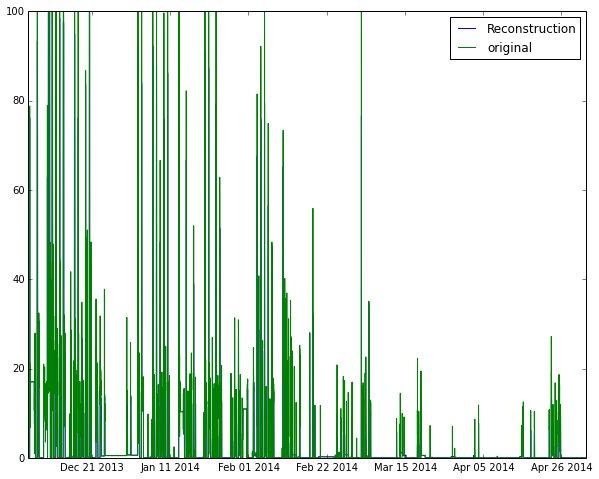

In [39]:
R=encoder.recon()
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plot(R.index,R,label='Reconstruction');
plot(S.index,S,label='original');
legend();

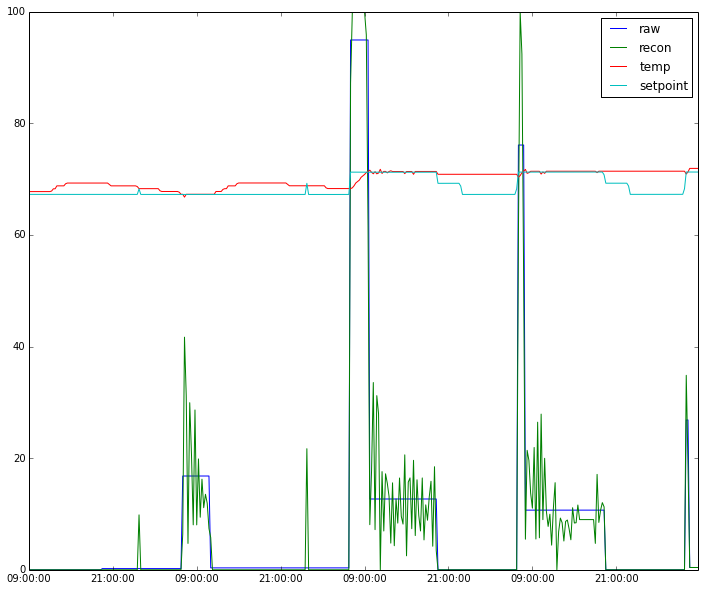

In [42]:
pylab.rcParams['figure.figsize'] = (12.0, 10.0)
week=96*4
start=1000
index=S.index[start:start+week]
plot(index,R[start:start+week],label='raw')
plot(index,S[start:start+week],label='recon')
plot(index,DF['Zone_Temperature'][start:start+week],label='temp')
plot(index,DF['Actual_Heating_Setpoint'][start:start+week],label='setpoint')
legend()

In [ ]:
print ','.join(['%d:%3.1f'%(i,subD[i]) for i in range(len(subD))])

In [ ]:
plot([Sol[i]['value'] for i in range(len(Sol))])

In [ ]:
sys.getsizeof(S)

In [ ]:
sys.getsizeof(Switch_points)

In [ ]:
sys.getsizeof(S.values)

In [74]:
sqrt(sum([s*s for s in S.values]))

398.26725078484247

In [57]:
B=A.dropna(subset=['Rooms'])
print size(A)
print size(B)
rooms=sorted(list(set(B.Room.values)))
rooms

54159040
54038720


In [87]:
cols = list(A.columns)
cols.remove('Room')
cols.remove('Temperature')
cols

['Actual_Cooling_Setpoint',
 'Actual_Heating_Setpoint',
 'Actual_Sup_Flow_SP',
 'Actual_Supply_Flow',
 'Common_Setpoint',
 'Cooling_Command',
 'Cooling_Max_Flow',
 'Heating_Command',
 'Occupied_Clg_Min',
 'Occupied_Command',
 'Occupied_Htg_Flow',
 'Reheat_Valve_Command',
 'WarmCool_Adjust',
 'Zone_Temperature']

In [100]:
std(S)

1.3816352350654886